# Libraries

In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib as plt
from keras import backend as K
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [45]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower() #lowercase
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)] 
    return sorted(data,key = alphanum_key)

# defining the size of the image
SIZE = 512
high_img = []
path = 'dataset/train/high_res/'
path2 = 'dataset/val/high_res/'
files = os.listdir(path)
files.extend(os.listdir(path2))
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = 'dataset/train/low_res/'
path2 = 'dataset/val/low_res/'
files = os.listdir(path)
files.extend(os.listdir(path2))

files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '855.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
     
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|████████████████████████████████████████| 855/855 [00:03<00:00, 267.53it/s]


# Plotting PSNR and SSIM Metrics

In [46]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

def SSIM(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))
def pixel_mse_loss(x,y):
    return tf.reduce_mean( (x - y) ** 2 )

def model_train_plot(history):
    
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    

    plt.plot(history.history['SSIM'])
    plt.plot(history.history['val_SSIM'])
    plt.title('model SSIM')
    plt.ylabel('SSIM')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['PSNR'])
    plt.plot(history.history['val_PSNR'])
    plt.title('model PSNR')
    plt.ylabel('PSNR')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [47]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:840]
validation_low_image = low_img[700:840]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[840:]
test_low_image = low_img[840:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3)) #(number of obvs,size,size,Color dimention)
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 512, 512, 3)
Shape of test images: (15, 512, 512, 3)
Shape of validation images: (140, 512, 512, 3)


In [48]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

# Models - baseline

In [ ]:
# test harness for evaluating models on the cifar10 dataset
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(512, 512, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2DTranspose(3, (2, 2),strides = 2))
model.add(Conv2DTranspose(64, (2, 2),strides = 2))
model.add(Conv2DTranspose(64, (2, 2),strides = 2))
model.add(Conv2DTranspose(64, (2, 2),strides = 2))
model.add(Conv2DTranspose(3, (2, 2),strides = 2))



In [49]:


model.summary()


In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc',PSNR, SSIM])
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(train_low_image, train_high_image, epochs = 20, batch_size = 16,callbacks=[earlystop_callback],
          validation_data = (validation_low_image,validation_high_image))

In [51]:
# test harness for evaluating models on the cifar10 dataset
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(512, 512, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2DTranspose(3, (2, 2),strides = 2))

In [52]:
mode.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 512, 512, 32)      896       
                                                                 
 conv2d_57 (Conv2D)          (None, 512, 512, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 256, 256, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 256, 256, 16)      9232      
                                                                 
 conv2d_59 (Conv2D)          (None, 256, 256, 64)      9280      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                

In [42]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc',PSNR, SSIM])
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(train_low_image, train_high_image, epochs = 20, batch_size = 16,callbacks=[earlystop_callback],
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/20


2023-04-17 21:37:12.590733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - ETA: 0s - loss: 0.1073 - acc: 0.5037 - PSNR: inf - SSIM: 0.5793

2023-04-17 21:37:41.602682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 32s 697ms/step - loss: 0.1073 - acc: 0.5037 - PSNR: inf - SSIM: 0.5793 - val_loss: 0.0347 - val_acc: 0.7262 - val_PSNR: 31.1508 - val_SSIM: 0.8056
Epoch 2/20
44/44 [==============================] - 29s 643ms/step - loss: 0.0257 - acc: 0.7835 - PSNR: 34.8105 - SSIM: 0.8860 - val_loss: 0.0242 - val_acc: 0.7770 - val_PSNR: 35.9754 - val_SSIM: 0.9007
Epoch 3/20
44/44 [==============================] - 29s 648ms/step - loss: 0.0225 - acc: 0.8094 - PSNR: 36.4884 - SSIM: 0.9118 - val_loss: 0.0222 - val_acc: 0.7819 - val_PSNR: 36.4617 - val_SSIM: 0.9119
Epoch 4/20
44/44 [==============================] - 29s 649ms/step - loss: 0.0215 - acc: 0.8133 - PSNR: 36.7638 - SSIM: 0.9170 - val_loss: 0.0218 - val_acc: 0.8193 - val_PSNR: 36.6707 - val_SSIM: 0.9103
Epoch 5/20
44/44 [==============================] - 29s 657ms/step - loss: 0.0197 - acc: 0.8293 - PSNR: 37.8033 - SSIM: 0.9277 - val_loss: 0.0195 - val_acc: 0.7991 - val_PSNR: 37.8661 - val_SSIM: 0.9299


In [43]:
model.save("baseline-simple-val-best.h5")
import pickle 

with open('baseline-simple-val-best.pkl','wb') as handle:
    pickle.dump(history.history,handle)


In [34]:
with open('baseline.pkl','rb') as handle:
    history = pickle.load(handle)

# Models - Concatenation

In [28]:
from keras import layers
def down_level(filters , kernel_size, apply_batch_normalization = False):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up_level(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    l1 = down_level(128,(3,3),False)(inputs)
    l2 = down_level(128,(3,3),False)(l1)
    l3 = down_level(256,(3,3),True)(l2)
    l4 = down_level(512,(3,3),True)(l3)
    
    l5 = down(512,(3,3),True)(l4)
#     d6 = down(1024,(3,3),True)(d5)
    #upsampling
#     u0 = up(1024,(3,3),False)(d6)
#     u0 = layers.concatenate([u0,d5])
    h1 = up_level(512,(3,3),False)(l5)
    h1 = layers.concatenate([h1,l4])
    h2 = up_level(256,(3,3),False)(h1)
    h2 = layers.concatenate([h2,l3])
    h3 = up_level(128,(3,3),False)(h2)
    h3 = layers.concatenate([h3,l2])
    h4 = up_level(128,(3,3),False)(h3)
    h4 = layers.concatenate([h4,l1])
    h5 = up_level(3,(3,3),False)(u4)
    h5 = layers.concatenate([h5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(uh5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_14 (Sequential)     (None, 256, 256, 12  3584        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_15 (Sequential)     (None, 128, 128, 12  147584      ['sequential_14[0][0]']          
                                8)                                                          

https://www.kaggle.com/code/nirawitkanthachai/low-resolution-images-to-high-resolution

In [29]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc',PSNR, SSIM])
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(train_low_image, train_high_image, epochs = 20, batch_size = 1,callbacks=[earlystop_callback],
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/20


2023-04-17 17:19:19.156801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


700/700 [==============================] - ETA: 0s - loss: 0.0386 - acc: 0.6495 - PSNR: 31.3012 - SSIM: 0.8666

2023-04-17 17:20:42.959194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


700/700 [==============================] - 93s 129ms/step - loss: 0.0386 - acc: 0.6495 - PSNR: 31.3012 - SSIM: 0.8666 - val_loss: 0.0256 - val_acc: 0.7292 - val_PSNR: 34.0718 - val_SSIM: 0.9258
Epoch 2/20
700/700 [==============================] - 89s 127ms/step - loss: 0.0217 - acc: 0.7853 - PSNR: 35.7429 - SSIM: 0.9303 - val_loss: 0.0196 - val_acc: 0.8110 - val_PSNR: 35.5403 - val_SSIM: 0.9461
Epoch 3/20
700/700 [==============================] - 88s 126ms/step - loss: 0.0184 - acc: 0.7992 - PSNR: 37.0852 - SSIM: 0.9501 - val_loss: 0.0164 - val_acc: 0.8438 - val_PSNR: 37.7973 - val_SSIM: 0.9527
Epoch 4/20
700/700 [==============================] - 88s 126ms/step - loss: 0.0155 - acc: 0.8278 - PSNR: 38.7620 - SSIM: 0.9578 - val_loss: 0.0148 - val_acc: 0.8316 - val_PSNR: 39.4523 - val_SSIM: 0.9581
Epoch 5/20
700/700 [==============================] - 88s 126ms/step - loss: 0.0149 - acc: 0.8297 - PSNR: 39.2518 - SSIM: 0.9598 - val_loss: 0.0145 - val_acc: 0.8944 - val_PSNR: 39.1065 - val

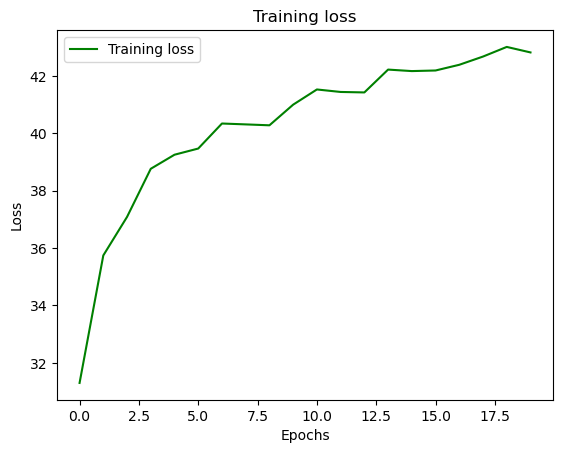

In [32]:
import matplotlib.pyplot as plt 
plt.plot(history.epoch, history.history["PSNR"], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing on a single image

In [ ]:
img = cv2.imread(r'test6.jpg',1)

 #resizing image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (SIZE, SIZE))
img = img.astype('float32') / 255.0


predicted = np.clip(model.predict(img.reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)
plot_images(img,img,predicted)

## Pickling model and saving history

In [33]:
model.save("final_model_psnr_512-val.h5")
import pickle 

with open('final_model_concate_512-val.pkl','wb') as handle:
    pickle.dump(history.history,handle)

# Models - Unet

In [34]:
def conv(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
def encoder(input, num_filters):
    x = conv(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p
def decoder(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv(x, num_filters)
    return x
def build_unet(input_shape):
    inputs = Input(input_shape)
    s1, p1 = encoder(inputs, 64)
    s2, p2 = encoder(p1, 128)
    s3, p3 = encoder(p2, 256)
    s4, p4 = encoder(p3, 512)
    b1 = conv(p4, 1024)
    d1 = decoder(b1, s4, 512)
    d2 = decoder(d1, s3, 256)
    d3 = decoder(d2, s2, 128)
    d4 = decoder(d3, s1, 64)


    outputs = Conv2D(3, 3, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

https://idiotdeveloper.com/unet-implementation-in-tensorflow-using-keras-api/

In [35]:
model = build_unet((512, 512, 3))

In [8]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 1024  4719616     ['max_pooling2d_3[0][0]']        
                                )                                                                 
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 32, 32, 1024  4096       ['conv2d_8[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 activation_8 (Activation)      (None, 32, 32, 1024  0           ['batch_normalization_8[0][0]']  
                                )                                                                 
                                                                                                  
 conv2d_9 

                                                                                                  
 activation_15 (Activation)     (None, 256, 256, 12  0           ['batch_normalization_15[0][0]'] 
                                8)                                                                
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 512, 512, 64  32832      ['activation_15[0][0]']          
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 512, 512, 12  0           ['conv2d_transpose_3[0][0]',     
                                8)                                'activation_1[0][0]']           
                                                                                                  
 conv2d_16

In [37]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc',PSNR, SSIM])
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
history = model.fit(train_low_image, train_high_image, epochs = 20, batch_size = 8,callbacks=[earlystop_callback],
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/20


2023-04-17 17:49:58.058119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - ETA: 0s - loss: 0.0718 - acc: 0.6217 - PSNR: 24.4548 - SSIM: 0.8299

2023-04-17 17:55:15.992176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 338s 4s/step - loss: 0.0718 - acc: 0.6217 - PSNR: 24.4548 - SSIM: 0.8299 - val_loss: 0.3873 - val_acc: 0.2943 - val_PSNR: 8.5912 - val_SSIM: 0.1916
Epoch 2/20
88/88 [==============================] - 337s 4s/step - loss: 0.0617 - acc: 0.6849 - PSNR: 25.7077 - SSIM: 0.8745 - val_loss: 0.1877 - val_acc: 0.4687 - val_PSNR: 15.6282 - val_SSIM: 0.6727
Epoch 3/20
88/88 [==============================] - 327s 4s/step - loss: 0.0606 - acc: 0.6869 - PSNR: 25.8678 - SSIM: 0.8840 - val_loss: 0.1484 - val_acc: 0.6314 - val_PSNR: 17.8022 - val_SSIM: 0.7336
Epoch 4/20
88/88 [==============================] - 329s 4s/step - loss: 0.0532 - acc: 0.6877 - PSNR: 26.8409 - SSIM: 0.8986 - val_loss: 0.1005 - val_acc: 0.6415 - val_PSNR: 21.5726 - val_SSIM: 0.7844
Epoch 5/20
88/88 [==============================] - 336s 4s/step - loss: 0.0553 - acc: 0.6999 - PSNR: 26.7540 - SSIM: 0.8982 - val_loss: 0.0873 - val_acc: 0.6644 - val_PSNR: 23.3583 - val_SSIM: 0.7822
Epoch 6

In [ ]:
for i in range(1,10):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    test_low_image[i] = cv2.cvtColor(test_low_image[i], cv2.COLOR_BGR2RGB)
    plot_images(test_high_image[i],test_low_image[i],predicted)

## Testing on a single image

In [ ]:
img = cv2.imread('woman.png',1)
#img = img[:96,:96,:]
print(img.shape)

        #resizing image
img = cv2.resize(img, (SIZE, SIZE))
img = img.astype('float32') / 255.0
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
predicted = np.clip(model.predict(img.reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2RGB)

plot_images(img,img,predicted)

## Pickling the model and history

In [39]:
model.save("unet-val.h5")
import pickle 

with open('unet-val.pkl','wb') as handle:
    pickle.dump(history.history,handle)